In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  

from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
import statsmodels
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 50
pd.options.display.max_columns = 200

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
#df=pd.read_csv('/path.csv', index_col='Date', parse_dates=True)
#df=df.dropna()
#df.shape
#df.head()

In [10]:
dx= web.DataReader('AAPL', data_source='yahoo', start='2014-01-01', end=dt.datetime.now())
dx

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,19.893929,19.715000,19.845715,19.754642,234684800.0,17.516613
2014-01-03,19.775000,19.301071,19.745001,19.320715,392467600.0,17.131840
2014-01-06,19.528570,19.057142,19.194643,19.426071,412610800.0,17.225262
2014-01-07,19.498571,19.211430,19.440001,19.287144,317209200.0,17.102070
2014-01-08,19.484285,19.238930,19.243214,19.409286,258529600.0,17.210381
...,...,...,...,...,...,...
2021-12-03,164.960007,159.720001,164.020004,161.839996,117938300.0,161.839996
2021-12-06,167.880005,164.279999,164.289993,165.320007,107497000.0,165.320007
2021-12-07,171.580002,168.339996,169.080002,171.179993,120405400.0,171.179993


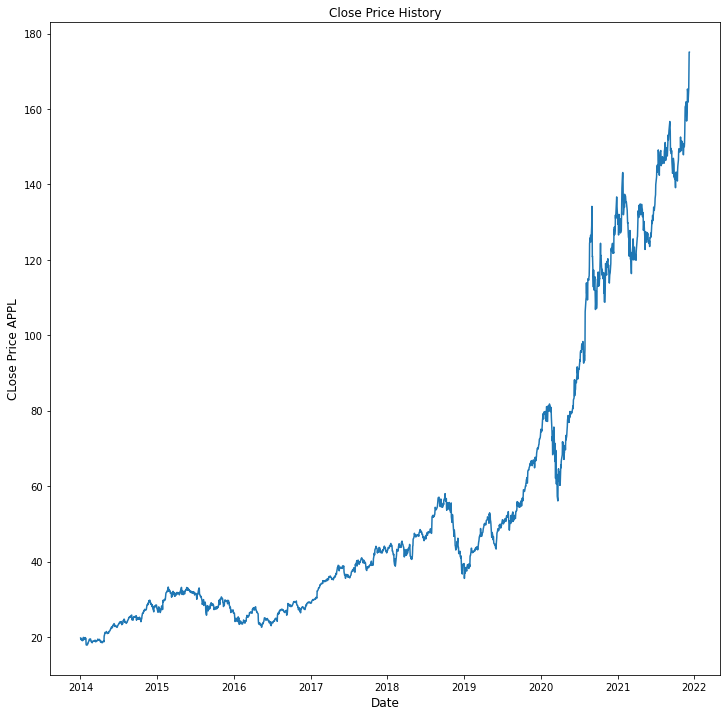

In [12]:
plt.figure(figsize=(12,12))
plt.title('Close Price History')
plt.plot(dx['Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('CLose Price APPL', fontsize=12)
plt.show()

In [36]:
df= web.DataReader('BTC-USD', data_source='yahoo', start='2014-01-01', end=dt.datetime.now())
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2021-12-05,49768.148438,47857.496094,49201.519531,49368.847656,3.719820e+10,49368.847656
2021-12-06,50929.519531,47281.035156,49413.480469,50582.625000,3.770731e+10,50582.625000
2021-12-07,51934.781250,50175.808594,50581.828125,50700.085938,3.367681e+10,50700.085938


In [37]:
df = df.rename({'High': 'btc_high', 'Low': 'btc_low','Open': 'btc_open', 'Close': 'btc_close','Volume':'btc_volume','Adj Close':'btc_adj_close'}, axis=1)
df.columns

Index(['btc_high', 'btc_low', 'btc_open', 'btc_close', 'btc_volume',
       'btc_adj_close'],
      dtype='object')

In [38]:
round(df.isna().sum()/len(df),4)*100

btc_high         0.0
btc_low          0.0
btc_open         0.0
btc_close        0.0
btc_volume       0.0
btc_adj_close    0.0
dtype: float64

In [39]:
df.dtypes

btc_high         float64
btc_low          float64
btc_open         float64
btc_close        float64
btc_volume       float64
btc_adj_close    float64
dtype: object

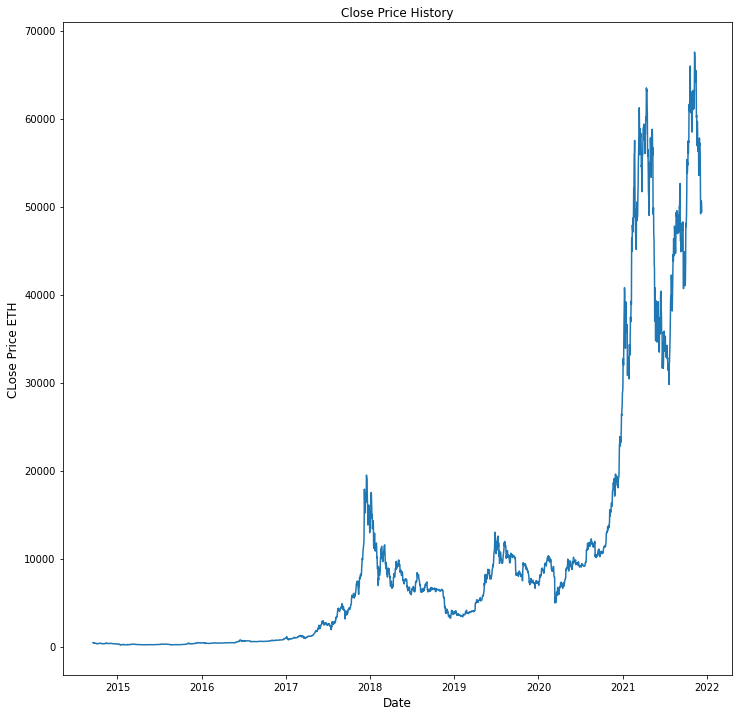

In [40]:
#Visualize the closing price history
plt.figure(figsize=(12,12))
plt.title('Close Price History')
plt.plot(df['btc_close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('CLose Price ETH', fontsize=12)
plt.show()

### Correlations

In [41]:
correlations = df.corr()["btc_close"]
correlations

btc_high         0.999482
btc_low          0.999384
btc_open         0.998808
btc_close        1.000000
btc_volume       0.746861
btc_adj_close    1.000000
Name: btc_close, dtype: float64

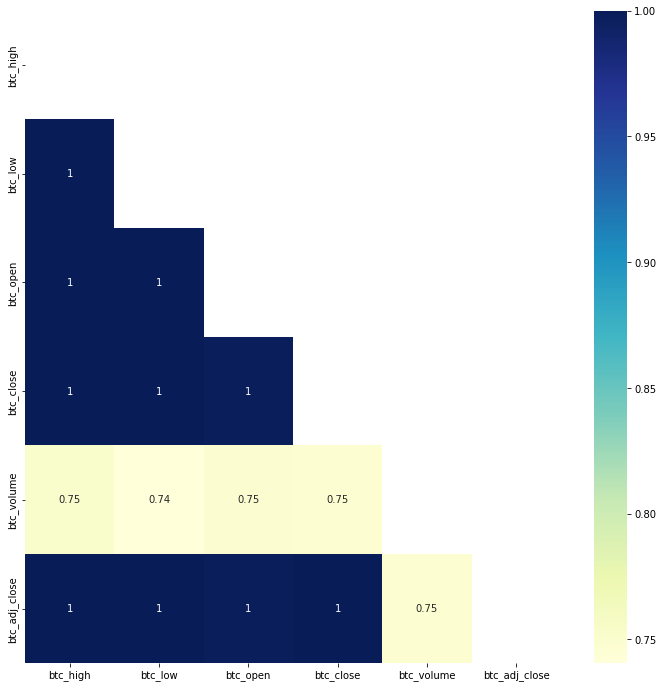

In [42]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(12, 12))
ax=sns.heatmap(df.corr(), mask=mask, annot=True,cmap="YlGnBu")
plt.show()

<AxesSubplot:xlabel='btc_volume'>

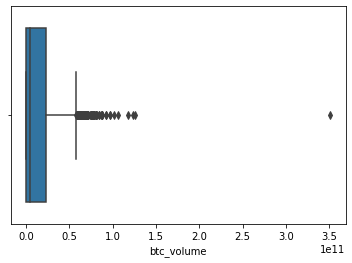

In [43]:
sns.boxplot(df.btc_volume)

<AxesSubplot:xlabel='btc_close'>

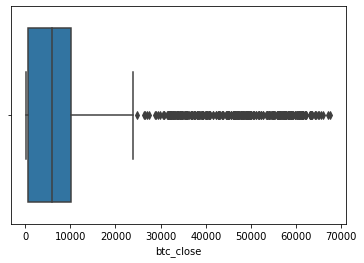

In [44]:
sns.boxplot(df.btc_close)

In [80]:
seasonality = seasonal_decompose(df.btc_close, model='additive', period=60)


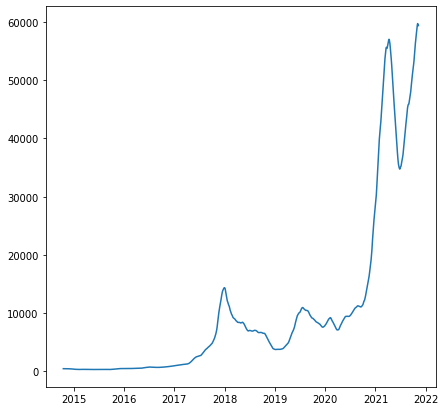

In [91]:
plt.figure(figsize=(7,7))
plt.plot(seasonality.trend)


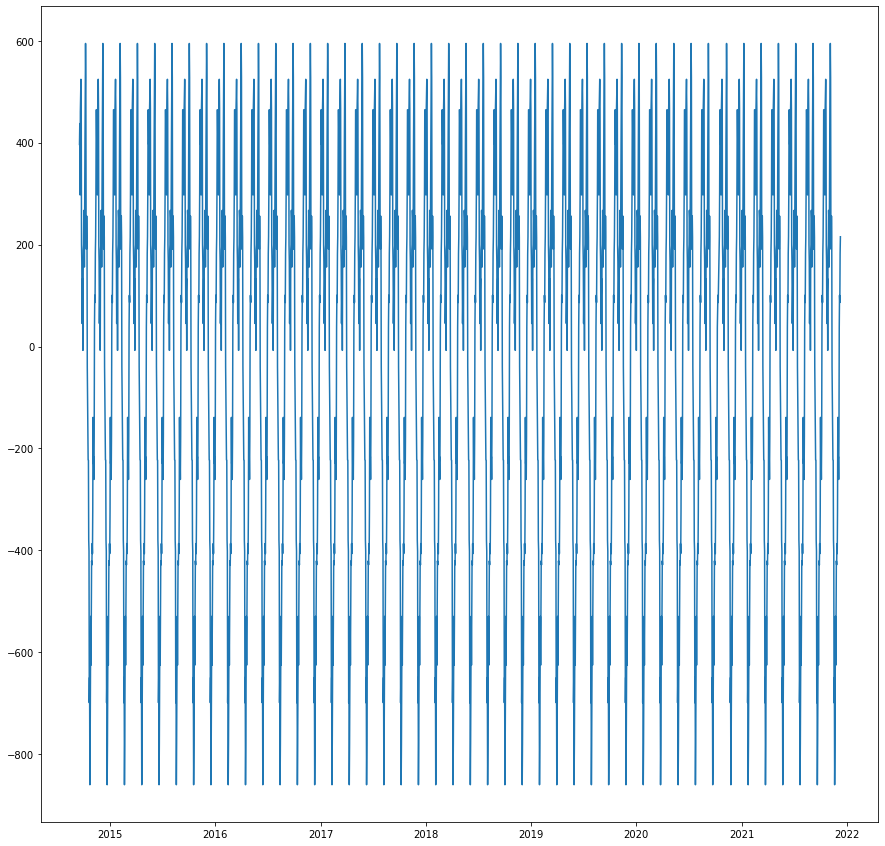

In [82]:
plt.figure(figsize=(15,15))
plt.plot(seasonality.seasonal)

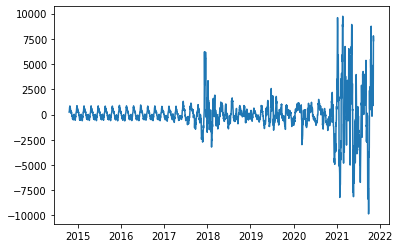

In [83]:
plt.plot(seasonality.resid)

In [85]:
seasonality = seasonal_decompose(df.btc_close, model='multiplicative', period=60)


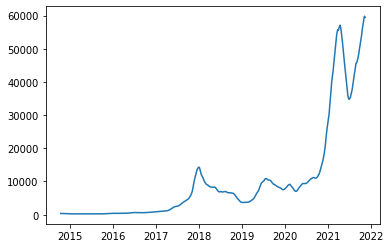

In [86]:
plt.plot(seasonality.trend)

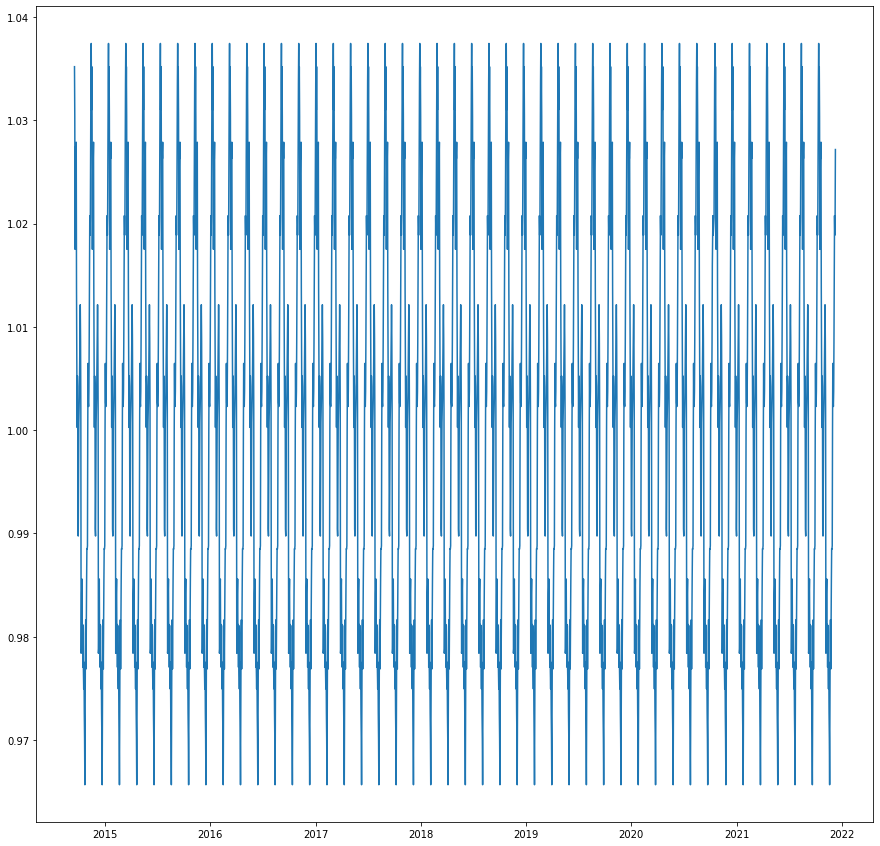

In [87]:
plt.figure(figsize=(15,15))
plt.plot(seasonality.seasonal)

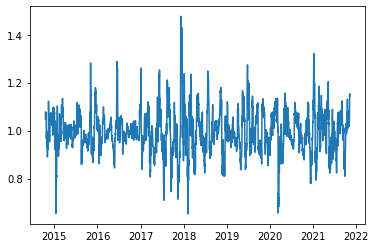

In [88]:
plt.plot(seasonality.resid)

In [45]:
newdf = df.filter(["btc_close",'btc_volume',"btc_open",'btc_high', 'btc_low'], axis=1)
newdf

,btc_close,btc_volume,btc_open,btc_high,btc_low
Date,,,,,
2014-09-17,457.334015,2.105680e+07,465.864014,468.174011,452.421997
2014-09-18,424.440002,3.448320e+07,456.859985,456.859985,413.104004
2014-09-19,394.795990,3.791970e+07,424.102997,427.834991,384.532013
2014-09-20,408.903992,3.686360e+07,394.673004,423.295990,389.882996
2014-09-21,398.821014,2.658010e+07,408.084991,412.425995,393.181000
...,...,...,...,...,...
2021-12-05,49368.847656,3.719820e+10,49201.519531,49768.148438,47857.496094
2021-12-06,50582.625000,3.770731e+10,49413.480469,50929.519531,47281.035156
2021-12-07,50700.085938,3.367681e+10,50581.828125,51934.781250,50175.808594


### Data Split

In [46]:
X=newdf.drop("btc_close", axis=1)
y=newdf.btc_close

In [47]:
X

,btc_volume,btc_open,btc_high,btc_low
Date,,,,
2014-09-17,2.105680e+07,465.864014,468.174011,452.421997
2014-09-18,3.448320e+07,456.859985,456.859985,413.104004
2014-09-19,3.791970e+07,424.102997,427.834991,384.532013
2014-09-20,3.686360e+07,394.673004,423.295990,389.882996
2014-09-21,2.658010e+07,408.084991,412.425995,393.181000
...,...,...,...,...
2021-12-05,3.719820e+10,49201.519531,49768.148438,47857.496094
2021-12-06,3.770731e+10,49413.480469,50929.519531,47281.035156
2021-12-07,3.367681e+10,50581.828125,51934.781250,50175.808594


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Scikit-learning 
model = LinearRegression()
model.fit(X_train, y_train)
# Predictions
predictions = model.predict(X_test)

# Main metrics
print('R2:', r2_score(y_test, predictions))
print('MAE:', mae(y_test, predictions))
print('MSE:', mse(y_test, predictions, squared=False))

R2: 0.9996934702642413
MAE: 113.00486350870678
MSE: 271.8199062392637


In [50]:
# Using Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)

predicted_price = regressor.predict(X_test)


print('R2:', r2_score(y_test, predicted_price))
print('MAE:', mae(y_test, predicted_price)) 
print('MSE:', mse(y_test,predicted_price, squared=False)) 
print('Root MSE:', np.sqrt(mse(y_test, predicted_price)))

R2: 0.9993729528781685
MAE: 163.05100546475612
MSE: 388.7720568644609
Root MSE: 388.7720568644609


### Scaling

+ Normalize the range of independent variables.

In [51]:
std_scaler=StandardScaler().fit(X_train) 

X_train_scaled=std_scaler.transform(X_train)

In [52]:
X_test_scaled=std_scaler.transform(X_test)

### Models with scaled data

+ Use linear regression and Random Forest Regressor for modelling
+ Training the model using .fit
+ Get the predictions on the X_test using the .predict() function
+ Observe the result of the main metrics: 

    + R-squared: check the correlation level 
    + Mean absolute error (MAE): measures the absolute errors between paired observations
    + Mean standard error (MSE): measures the average squared difference between the estimated values and the actual value.


+ Check the main metrics using OLS (Ordinary Least Squares regression)


In [53]:
# OLS Regression

X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              btc_close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.222e+06
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        13:50:07   Log-Likelihood:                -15151.
No. Observations:                2109   AIC:                         3.031e+04
Df Residuals:                    2104   BIC:                         3.034e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.044e+04      6.955   1501.201      0.0

In [54]:
y_pred

array([32848.36971211,  6768.50935985,  3440.27193501,   242.14537956,
       11120.41367832,   302.94440482,   262.4614137 ,   294.75858106,
         409.56495092,   229.69294608, 37378.2332915 , 38546.38504259,
        9276.46373787,   252.24904867,   340.36936303,  9974.77223215,
        8893.05904412,   261.11674032, 40467.10451668,  8765.02029298,
       11837.89334656,  9314.32775886, 11524.18910954, 15004.38871299,
       38835.26503134,   332.21812781, 13056.88246045,   788.5420217 ,
         453.46633191,  3895.5143039 ,  3480.58412849,   939.53935904,
        8185.30469054,  2533.43338938,   394.45579276,  9169.23850225,
        6865.16206401,   394.32284927,  2539.66713393,   734.0294291 ,
       45202.06943717,  7654.57531726,  8228.17051485,  8597.04725025,
         311.40399378,   476.77462927,  9548.68663213,   363.29718556,
         296.99730043, 54999.73266923,   293.06697178,  1063.22778121,
         386.2858209 ,  3627.49470513, 24709.18438384,   260.73534659,
      

In [55]:
# Sckit-learning
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

y
y_pred=model.predict(X_test_scaled)   # model prediction


y_pred_train=model.predict(X_train_scaled)

print('R2:', r2_score(y_test, y_pred))
print('MAE:', mae(y_test, y_pred))
print('MSE:', mse(y_test,y_pred, squared=False))

R2: 0.9996934702642406
MAE: 113.0048635082293
MSE: 271.8199062395613


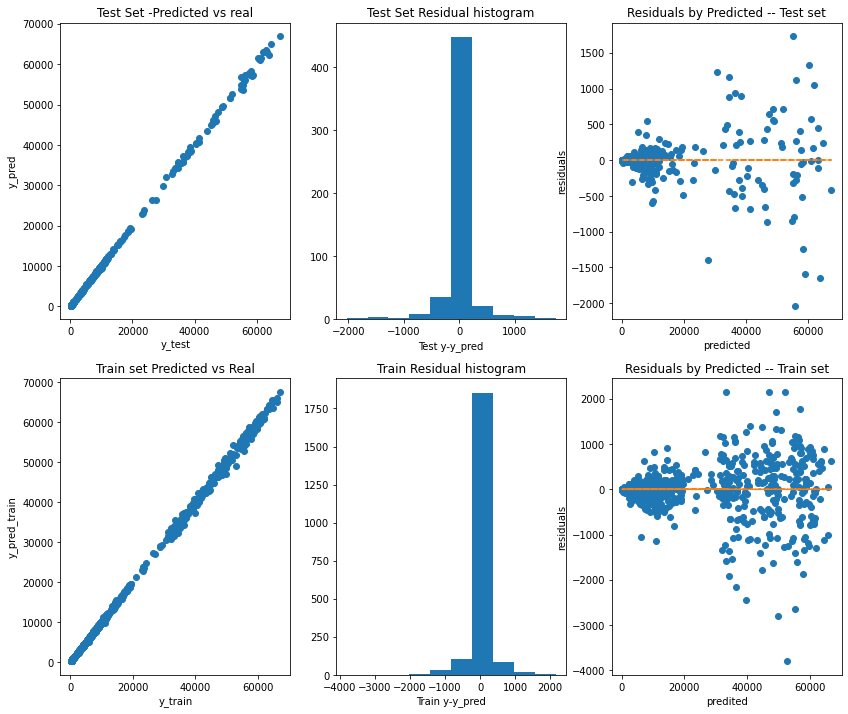

In [56]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(2,3,figsize=(14,12))
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[0,2].plot(y_pred,y_test - y_pred,"o")
ax[0,2].set_xlabel("predicted")
ax[0,2].set_ylabel("residuals")
ax[0,2].set_title("Residuals by Predicted -- Test set")
ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')


ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs Real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
ax[1,2].set_xlabel("predited")
ax[1,2].set_ylabel("residuals")
ax[1,2].set_title("Residuals by Predicted -- Train set")
ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')

In [57]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

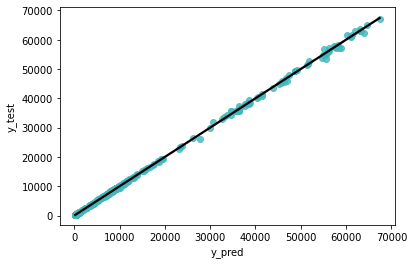

In [58]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "#42B7BD"}, line_kws={"color": "black"})

### Feature Importance

In [59]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by=["Importance"], ascending=False)

In [60]:
round(features_importances.head(50),1)

,Attribute,Importance
2,btc_high,14309.0
3,btc_low,8989.5
1,btc_open,7917.0
0,btc_volume,2.9


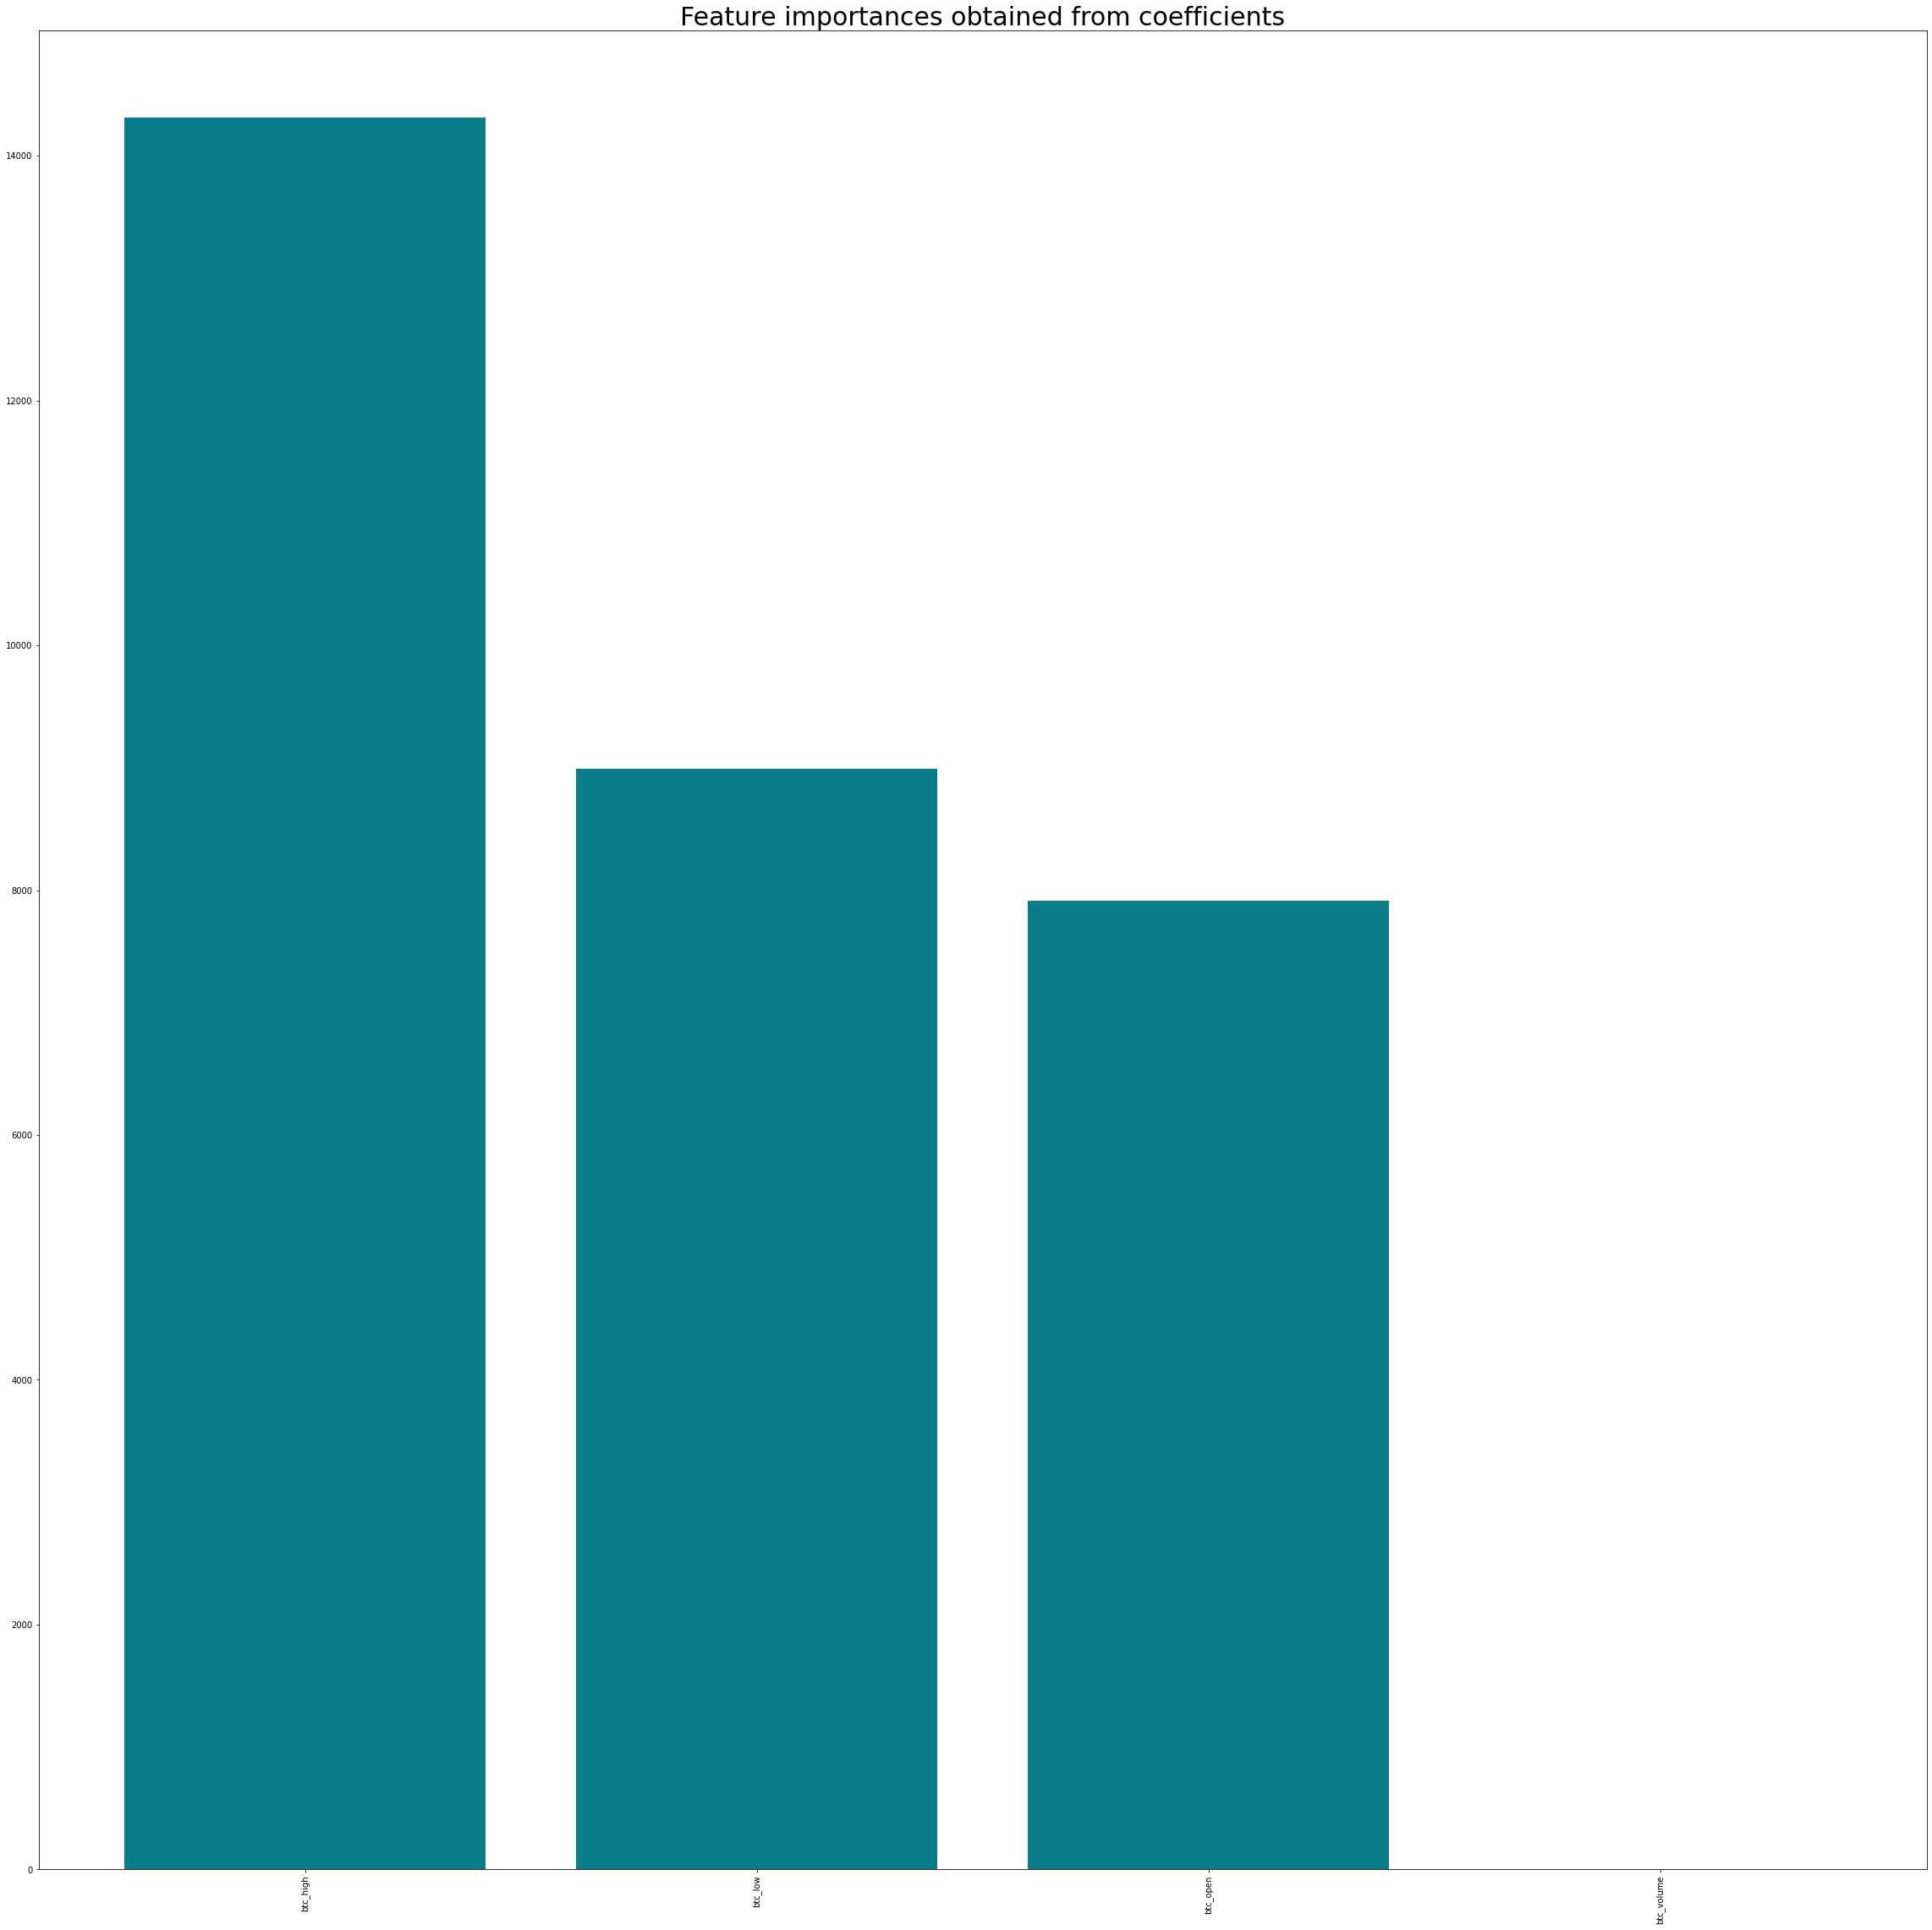

In [61]:
plt.figure(figsize=(40,40))
plt.bar(x=features_importances['Attribute'], height=features_importances["Importance"], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=30)
plt.xticks(rotation='vertical')
plt.show()

In [62]:
# How to make fontsize bigger?

In [63]:
#predition into the future???
projection=14

# Long short-term memory (LSTM)